In [1]:
from __future__ import print_function
import os
import time
import h5py as h5
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

print ("Numpy      ver. ", np.__version__)
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)
print ("Keras      ver. ", keras.__version__)

#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#np.random.seed(777)
#tf.set_random_seed(777)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline


Numpy      ver.  1.17.4
H5Py       ver.  2.9.0
SKLearn    ver.  0.21.3
TensorFlow ver.  1.15.0
Keras      ver.  2.2.4-tf


In [2]:
H5_FILE="../white_h_4096_dm2.h5"
H5_FILE="../white_h_8192_dm1.h5"
H5_FILE="../white_h_8192_dm2.h5"
#!wget http://grqc.ncts.ncku.edu.tw/~lincy/GWDA/white_h_8192_dm2.h5
#!ls /tmp/tf_tmp -al

# Load data
import GWDA.loader
GWdata = GWDA.loader.GWInject(H5_FILE, plot=0)
RATE   = GWdata.srate
print("Sampling rate : ", RATE)

#X0, Y0 = GWdata.get_train_set(nc=5)
#GWDA.loader.plot_template(H5_FILE)

Sampling rate :  8192


In [3]:
###
###  Construct TF graph
###

#ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_model'
ROOT_FOLDER = '/work/p00lcy01/save/kcnn3_relu'

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

tf.reset_default_graph()
DIM   = RATE
LRATE        = 1e-5   ##-4
#keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
#lrate     = tf.placeholder(tf.float32)
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

##########################################
##import GWDA.model
###########################################
##logits = GWDA.model.CNN_3(x, keep_prob, DIM)
F = [16,32,64]
K = [16, 8, 8]
D = [ 1, 1, 1]
S = [ 1, 1, 1]
PO= [ 4, 4, 4]
PS= [ 4, 4, 4]
#args0 = { "padding":'valid', "data_format":"channels_first" }
args0 = { "padding":'valid', "data_format":"channels_last" }
act = 'elu'
act = 'tanh'
act = 'relu'
act = tf.nn.relu
ki  = keras.initializers.TruncatedNormal() ##(seed=2)
ki0 = keras.initializers.Zeros()
input_data = keras.layers.Input(shape=(RATE,1))
a1=keras.layers.Conv1D(F[0], K[0], S[0], dilation_rate=D[0], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(input_data)
a1=keras.layers.MaxPooling1D(PO[0], PS[0], **args0)(a1)
a1=keras.layers.Conv1D(F[1], K[1], S[1], dilation_rate=D[1], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
a1=keras.layers.MaxPooling1D(PO[1], PS[1], **args0)(a1)
a1=keras.layers.Conv1D(F[2], K[2], S[2], dilation_rate=D[2], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
a1=keras.layers.MaxPooling1D(PO[2], PS[2], **args0)(a1)
a1=keras.layers.Flatten()(a1)
a2=keras.layers.Dense(64, kernel_initializer=ki, bias_initializer=ki0, activation=act, name='fc1')(a1)
a2=keras.layers.Dense(1, activation='sigmoid', name='prediction')(a2)
model = keras.models.Model(input_data, [a2])

def recall_m(y_true, y_pred):
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    pp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true, 0, 1)))
    recall = tp / (pp + keras.backend.epsilon())
    return recall

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=LRATE),
              metrics=['accuracy', recall_m])

model.summary()

# Compute predictions
#predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
#predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
#loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
#with tf.name_scope('optimizer'):
#    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)

#model.fit(x_train, y_train, batch_size=128 * 2, epochs=2, verbose=1, validation_data=(x_test, y_test))


#### Load / Save 


#### Save model
if not os.path.exists(ROOT_FOLDER):
    os.makedirs(ROOT_FOLDER)
model_json = model.to_json()
modelcpt = "%s/model.json" % (ROOT_FOLDER) 
with open(modelcpt, "w") as json_file:
    json_file.write(model_json)
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8192, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8177, 16)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2044, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2037, 32)          4128      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (No

In [4]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope("summaries_%s"% var.name.replace("/", "_").replace(":", "_")):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

    
### check all vari\ables
#tf.global_variables_initializer()
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        #variable_summaries(v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 16) dtype=float32>
<tf.Variable 'conv1d/bias:0' shape=(16,) dtype=float32>
<tf.Variable 'conv1d_1/kernel:0' shape=(8, 16, 32) dtype=float32>
<tf.Variable 'conv1d_1/bias:0' shape=(32,) dtype=float32>
<tf.Variable 'conv1d_2/kernel:0' shape=(8, 32, 64) dtype=float32>
<tf.Variable 'conv1d_2/bias:0' shape=(64,) dtype=float32>
<tf.Variable 'fc1/kernel:0' shape=(8000, 64) dtype=float32>
<tf.Variable 'fc1/bias:0' shape=(64,) dtype=float32>
<tf.Variable 'prediction/kernel:0' shape=(64, 1) dtype=float32>
<tf.Variable 'prediction/bias:0' shape=(1,) dtype=float32>
Whole size: 4.066 MB | Var # : 10
<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 16) dtype=float32>
<tf.Variable 'conv1d/bias:0' shape=(16,) dtype=float32>
<tf.Variable 'conv1d_1/kernel:0' shape=(8, 16, 32) dtype=float32>
<tf.Variable 'conv1d_1/bias:0' shape=(32,) dtype=float32>
<tf.Variable 'conv1d_2/kernel:0' shape=(8, 32, 64) dtype=float32>
<tf.Variable 'conv1d_2/bias:0' shape=(64,) dtype=flo

In [5]:
BATCH = 512
EPOCHS = 5000
MONITOR = 10
NOISE_COPY = 10

PATIENCE    = 5
PATIENCE_PT = 2
LRATE_FACTOR = 0.75
LRATE_MIN    = 1e-6

#TOLLERENCE = 1.e-4
TOLLERENCE = 1.e-9
##TOLLERENCE = 1.e-5

print(model.metrics_names)


['loss', 'acc', 'recall_m']


In [6]:
# 使用 tensorboard 監控訓練過程
#tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
# 在 patience 個 epochs 內，被監控的 val_loss 都沒有下降，那麼就降低 learning rate，新的值為 lr = factor * lr_old
#lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience=3)

In [7]:
##
##  Training with fixed template ....
##

#TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A =   [2.0,1.6,1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]
#TRAIN_A =   [1.4,1.2,1.0,0.8]

TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]

def calculate_learning_rate(e):
    DECAY=0.995
    if e>400:
        return LRATE*DECAY**((e-400)/10)
    else:
        return LRATE

###=================================================
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())   ### init w, bias to gaussian noise
    merged = tf.summary.merge_all()   ## call merged to do every summary

    try:
        CKPT = ""
        model.load_weights(CKPT)
        print("== Load weight from ", CKPT)
    except:
        print("== Trainning for scratch ==" )

    
    fig0 = plt.figure() ## plt loss 

    for amp in TRAIN_A:
        ## summarize to a new folder
        ##train_writer = tf.summary.FileWriter("%s/train_%4.2f" % (ROOT_FOLDER, amp ) )
        ##train_writer.add_graph(tf.get_default_graph())
        ###print('Saving graph to: %s' % ROOT_FOLDER)

        sess.run(tf.local_variables_initializer())  ###  only local vars like TP, TN, FP, FN to be init

        time0 = time.time()
        X0, Y0 = GWdata.get_train_set(A=amp, nc=NOISE_COPY)
        X1, Y1 = GWdata.get_val_set(A=amp, nc=NOISE_COPY)
        X = np.vstack( (X0,X1) ).astype('float32')
        Y = np.vstack( (Y0,Y1) ).astype('float32') 
        #Y = Y.astype('float32')
        print(X.shape)
        X = np.expand_dims(X, axis=-1)  
        print(X.shape)

        print("== Amp: %f with template size %d. Stage-in time: %f s"% (amp, len(X), time.time()-time0  ))
        
        patience    = 0
        patience_pt = 0
        time0 = time.time()

        el_in_epoches = []
        tl_in_epoches = []
        ea_in_epoches = []
        ta_in_epoches = []

        loss0 = 0
        for e in range(EPOCHS):

            #learning_rate = calculate_learning_rate(e)
            #keras.backend.set_value(model.optimizer.lr, learning_rate)

            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=777)   ##None

            STEPS   = int(len(Xt) / BATCH) 
            tl_ = 0
            ta_ = 0
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH]
                ybatch = Yt[i*BATCH:(i+1)*BATCH]

                tl_, ta_, re_ = model.train_on_batch(xbatch, ybatch)
                #print (tl_, ta_, re_)

            tl_in_epoches.append(tl_)
            ta_in_epoches.append(ta_)

            ### evaluate    
            el, ea, er = model.evaluate(Xv, Yv, verbose=0)   #, batch_size=128
            el_in_epoches.append(el)
            ea_in_epoches.append(ea)
            es = 0
            
            #print("loss:%f %f acc: %f %f" %(tl_, el, ta_, ea))

            if e % MONITOR == 0:
                duration = time.time() - time0
                speed = STEPS * BATCH * (e+1) / duration
                print('  Epoch: %3d, loss: %10.3e %10.3e a/s: %4.2g %4.2f re: %4.2f speed: %4.0f wf/s lr=%.4e' 
                      % (e, tl_, el, ea, es, er, speed, keras.backend.get_value(model.optimizer.lr) ) )
            
            ## Check convergence
            if el < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0

            ## ReduceLROnPlateau    
            if el >= loss0:
                loss0 = el
                if patience_pt > PATIENCE_PT: 
                    lr_ = keras.backend.get_value(model.optimizer.lr)
                    if lr_ > LRATE_MIN: keras.backend.set_value(model.optimizer.lr, lr_ * LRATE_FACTOR)
                    continue
                patience_pt += 1
            else:
                    patience_pt = 0
        
        ### 
        model.save_weights("%s/model_%4.2f.h5" % (ROOT_FOLDER, amp ))
        print("Saved weight with A = ", amp)

        ### dump loss history
        with open("%s/loss.history" % (ROOT_FOLDER), 'a') as f:
            f.write("### A=%d\n" % (amp) )
            for i in range( len(losshis_train) ):
                f.write("%5d %e %e\n" % ( i, losshis_train[i], losshis_val[i])  )
            f.write("\n\n")

        ### plot in each epoch
        plt.semilogy(el_in_epoches,      lw=1, label="A=%s"%amp)
        plt.semilogy(tl_in_epoches, '.', lw=1)
 
        plt.legend()
        fig_loss.savefig("%s/loss_history_%f.png" % (ROOT_FOLDER, amp))
        
plt.legend()
fig0.savefig("loss.png")

== Trainning for scratch ==
(14773, 8192)
(14773, 8192, 1)
== Amp: 1.800000 with template size 14773. Stage-in time: 4.747114 s
  Epoch:   0, loss:  3.163e-01  3.207e-01 a/s: 0.91 0.00 re: 0.00 speed: 2480 wf/s lr=1.0000e-04
  Epoch:  10, loss:  9.569e-04  1.049e-03 a/s:    1 0.00 re: 0.96 speed: 9512 wf/s lr=1.0000e-04
  Epoch:  20, loss:  1.635e-04  1.998e-04 a/s:    1 0.00 re: 0.96 speed: 11351 wf/s lr=1.0000e-04
  Epoch:  30, loss:  6.639e-05  8.619e-05 a/s:    1 0.00 re: 0.96 speed: 12150 wf/s lr=1.0000e-04
  Epoch:  40, loss:  3.798e-05  5.100e-05 a/s:    1 0.00 re: 0.96 speed: 12705 wf/s lr=1.0000e-04
  Epoch:  50, loss:  2.605e-05  3.571e-05 a/s:    1 0.00 re: 0.96 speed: 13092 wf/s lr=1.0000e-04
  Epoch:  60, loss:  1.899e-05  2.647e-05 a/s:    1 0.00 re: 0.96 speed: 13364 wf/s lr=1.0000e-04
  Epoch:  70, loss:  1.492e-05  2.100e-05 a/s:    1 0.00 re: 0.96 speed: 13552 wf/s lr=1.0000e-04
  Epoch:  80, loss:  1.211e-05  1.705e-05 a/s:    1 0.00 re: 0.96 speed: 13693 wf/s lr=1.0

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
####
####  Just for testing
####

NUM_AUC=200000
thres=[10**(-i)-(1e-11) for i in range(10,-1,-1)]
print(thres)
_, fna = tf.metrics.false_negatives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, fpa = tf.metrics.false_positives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, tna = tf.metrics.true_negatives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, tpa = tf.metrics.true_positives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
print (fna)
    

In [ ]:
###
###  Testing...
###
BATCH = 4096
ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_tmp'

TRAIN_A = [1.0]
TRAIN_A =   [1.6, 1.4, 1.2, 1.0, 0.8]

TEST_LIST = [1.5, 1.4, 1.3, 1.2,1.1,1.0,0.9,0.8,0.7,0.5,0.4,0.3,0.2,0.1,0.05]


with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    plt.figure()
    for m in TRAIN_A:
        #try:
        load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
        #except: 
        ##    continue
        #print("Saved model to disk")
        # load weights into new model
        loaded_model.load_weights("model.h5")
        print("Loaded model from disk")


        gacc=[]
        gsen=[]

        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_test_set(A=amp)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    #plt.show()
    plt.savefig("infer.png")


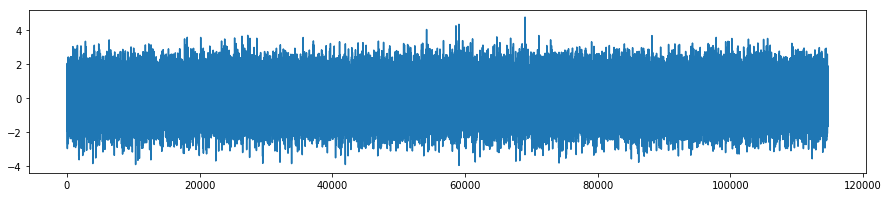

INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_0.80.ckpt


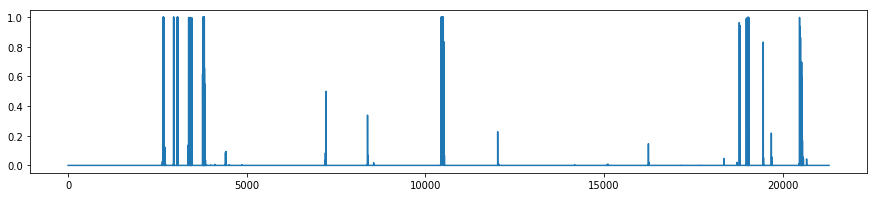

In [26]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_tmp'
TRAIN_A = [0.8]


SKIP = RATE  ##4*RATE   ## to remove the FFT gibbs effect
data = np.load("../real8k/GW150914_H1_w.npy")[SKIP:-SKIP]
plt.figure(**wopt)
plt.plot(data)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 100   ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())


In [27]:
###
###  Testing fake data...
###
ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_tmp'

TRAIN_A = [0.8]

def gen():
    
    tmp = GWInject(H5_FILE)
    inj = tmp.f['train_hp'][10]

    data = np.random.normal(0,0.0,RATE*2)
    data[:RATE] += inj 
    return data

data = gen()
plt.figure(**wopt)
plt.plot(data)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver(max_to_keep=50)

    load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, TRAIN_A[-1] ) )
    sess.run(tf.local_variables_initializer())

    ## predict batch-by-batch    
    DS  = 400    ## every ~200 ms
    dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
    MB  = 256
    prob = np.zeros(dsn)
    for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

        batch  = min(i+MB, dsn) - i                 ### take care the tail
        xbatch = np.zeros([batch, RATE])
        for b in range(batch):
            s = int((b+i)*DS)
            xbatch[b,:] = data[s:s+RATE]
        [p_] = sess.run([predict_prob], feed_dict={ x: xbatch })
        prob[i: i + batch] = p_.flatten()
    
        
plt.figure(**wopt)
plt.plot(prob.flatten())



NameError: global name 'GWInject' is not defined

8192 0


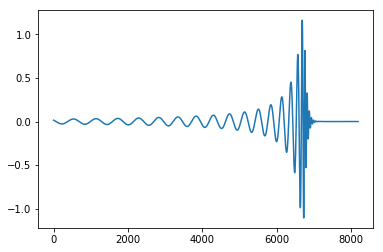